# Mutual information maximization

\begin{align}
I(X; Z) = \mathbb{E}_{P(x, z)}\left[\log\frac{P(x, z)}{P(x)P(z)}\right]
\end{align}
where $P(x), P(z)$ are the marginal distributions of the joint distribution $P(x, z)$. 

Given we only observe a dataset $\mathcal{D} = \{x\}$ and we aim to build a latent space using an encoder $Q_{\theta}(z|x)$, our model distribution is therefore $P_{\theta}(x, z) = Q_{\theta}(z|x)P(x)$.

We could easily lowerbound MI using the encoder:
\begin{align}
\begin{split}
I(X; Z) &= \mathbb{E}_{P(x, z)}\left[\log\frac{P(z|x)}{P(z)}\right] \\
&= \mathbb{E}_{P(x, z)}\left[\log\frac{P(z|x)Q(z|x)}{Q(z|x)}\right] - \mathbb{E}_{P(z)}[\log P(z)] \\
&= \mathbb{E}_{P(x, z)}\left[\log Q(z|x)\right] - \mathbb{E}_{P(z)}[\log P(z)] + \mathbb{E}_{P(x)}D_{KL}(P(z|x) || Q(z|x)) \\
&\geq \mathbb{E}_{P(x, z)}\left[\log Q(z|x)\right] - \mathbb{E}_{P(z)}[\log P(z)] \triangleq I_{\text{BA}}
\end{split}
\end{align}
and estimating MI becomes maximizing the above bound w.r.t. $Q_{\theta}$. This is the Barber & Agakov bound used in [InfoGAN](https://arxiv.org/abs/1606.03657). However, this would require us to estimate the intractable $P(z) = \int_{x}P(z|x)P(x)$. 

To solve this problem, we look to energy based bounds.

Consider energy-based distribution:
\begin{align}
Q(x|z) = \frac{P(x)e^{f(x, z)}}{Z(z)}, \text{ where } Z(z) = \mathbb{E}_{P(x)}[e^{f(x, z)}]
\end{align}

Switching the positions of $x, z$ in the above lower bound, we get:
\begin{align}
\begin{split}
\mathbb{E}_{P(x, z)}[\log \frac{P(x)e^{f(x, z)}}{Z(z)}] = \mathbb{E}_{P(x, z)}[f(x, z)] - \mathbb{E}_{P(z)}[\log Z(z)] + C
\end{split}
\end{align}

To further lower bound the above, we construct an upper bound on the partition function using the following relationship:
\begin{align}
\log(x) \leq \frac{x}{a} + \log(a) - 1
\end{align}
This gives us the following lower bound:
\begin{align}
\begin{split}
&\mathbb{E}_{P(x, z)}[f(x, z)] - \mathbb{E}_{P(z)}\left[\frac{\mathbb{E}_{P(x)}[e^{f(x, z)}]}{a(z)} + \log(a(z)) - 1\right] \\
&= \mathbb{E}_{P(x, z)}[f(x, z)] - \mathbb{E}_{P(x)P(z)}\left[\frac{e^{f(x, z)}}{e^{\log(a(z))}} + \log(a(z)) - 1\right] \\
&= \mathbb{E}_{P(x, z)}[f(x, z)] - \mathbb{E}_{P(x)P(z)}\left[e^{f(x, z) - \log(a(z))} + \log(a(z))\right] + 1 \triangleq I_{\text{TUBA}}
\end{split}
\end{align}
This bound is referred to as the tracktable unnormalized BA bound. We may also set $a(z)$ to a constant, but this would require the energy function $f(x, z)$ to self-normalize. This has no negative impact in emperic experiments, tho it tends to have high variance. The corresponding bound of Nguyen, Wainwright, and Jordan is:
\begin{align}
&\mathbb{E}_{P(x, z)}[f(x, z)] - e^{-1} \mathbb{E}_{P(z)} [Z(z)] \triangleq I_{\text{NWJ}}
\end{align}

For multi-sample bounds, the idea is to leverage multiple negative samples and make $a(z)$ depends on multiple $x$'s, i.e., $a(z; x_{1:K})$. We then design the energy function as:
\begin{align}
\log \frac{e^{f(x_1, z)}}{a(z; x_{1:K})}, \text{ where } a(z; x_{1:K}) = \frac{1}{K}\sum_{i=1}^{K}e^{f(x_i, z)}
\end{align}

The TUBA lower bound becomes:
\begin{align}
\mathbb{E}_{P(x_{1:K}, z)}\left[\log \frac{e^{f(x_1, z)}}{a(z; x_{1:K})}\right] - \mathbb{E}_{P(x_{1:K})P(z)}\left[\frac{e^{f(x_1, z)}}{a(z; x_{1:K})}\right]
\end{align}

We can show that the second term becomes 1 when averaged over $K$ samples:
\begin{align}
\begin{split}
\mathbb{E}_{P(x_{1:K})P(z)}\left[\frac{e^{f(x_1, z)}}{a(z; x_{1:K})}\right] &= \frac{1}{K}\sum_{i=1}^{K}\mathbb{E}_{P(x_{1:K})P(z)}\left[\frac{e^{f(x_i, z)}}{a(z; x_{1:K})}\right] = \mathbb{E}_{P(x_{1:K})P(z)}\left[\frac{\frac{1}{K}\sum_{i=1}^{K}e^{f(x_i, z)}}{a(z; x_{1:K})}\right] = 1
\end{split}
\end{align}

Applying the sample average and keeping only the first term, the lower becomes:
\begin{align}
\mathbb{E}_{P(x_{1:K}, z)}\left[\frac{1}{K}\sum_{i=1}^{K}\log \frac{e^{f(x_i, z_i)}}{\frac{1}{K}\sum_{j=1}^{K}e^{f(x_j, z_i)}}\right] = \mathbb{E}_{P(x_{1:K}, z)}\left[\sum_{i=1}^{K}\log \frac{e^{f(x_i, z_i)}}{\sum_{j=1}^{K}e^{f(x_j, z_i)}}\right] \triangleq I_{\text{NCE}}
\end{align}

Optimizing the critic with $I_{\text{NWJ}}$ can be challending due to its high variance. Instead, it can be optimized using the lower bound of Jensen-Shannon (JS) divergence. It uses the density ratio estimate from the JS critic to construct a critic for the KL lower bound, where the optimal one is given by
\begin{align}
T^{*}(x) = 1 + \log \frac{p(x)}{q(x)}
\end{align}

If we use this formulation and parametrize the critic with a softplus activation we can find the density function from the real-valued logits $V(x)$
\begin{align}
\frac{p(x)}{q(x)} \approx \exp(V(x))
\end{align}

We can use a critic for the KL divergence $T_{KL}(x) = 1 + V(x)$ to get a lower bound on the $I_{\text{NWJ}}$ objective. In case of mutual information $p$ is the joint distribution $p(x,z)$ and q is the product of the marginals $p(x)p(z)$ bringing the lower bound
\begin{align}
I(X;Y) \leq 1 + \mathbb{E}_{P(x, z)}\left[V(x,y)\right] - \mathbb{E}_{P(x)P(z)}\left[\exp(V(x,y))\right] \triangleq I_{\text{JS}}
\end{align}

### Implementation trick
The intuition there is for a given $z$, maximize the energy of the corresponding $x$ (i.e., the $x$ used to generate the $z$) and minimize the energy of all other $x$'s. 

For the NCE loss, for form a $K \times K$ energy matrix using samples from the batch. The diagonal entries constitute the positive samples and the off diagonal entries are the negative samples. For each row, we compute the numerator for the diagonal entries while normalizing along each row. We then maximize this value. 

For the TUBA loss, the naive implementation would be to sample a batch of $x$, compute the latent $z$, and use the $x$ and $z$ to evaluate the positive term. For the negative term, we use the same $z$ from the positive term but sample a different batch of $x'$. This way we make sure that the $x$ and $z$ are independent. 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as torch_dist

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

eps = 1e-6

font_size = 14
strip_size = 12

plt.rc('font', size=font_size)            # controls default text sizes
plt.rc('axes', titlesize=font_size)       # fontsize of the axes title
plt.rc('axes', labelsize=strip_size)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=strip_size)       # fontsize of the tick labels
plt.rc('ytick', labelsize=strip_size)       # fontsize of the tick labels
plt.rc('legend', fontsize=strip_size)       # legend fontsize

In [6]:
def sample_8_gaussians(num_samples):
    z = torch.randn(num_samples, 2)
    scale = 4
    sq2 = 1/np.sqrt(2)
    centers = [(1,0), (-1,0), (0,1), (0,-1), (sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
    # centers = [(1,0), (-1,0), (0,1), (0,-1)]
    # centers = [(sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
    centers = torch.tensor([(scale * x, scale * y) for x,y in centers])
    return sq2 * (0.5 * z + centers[torch.randint(len(centers), size=(num_samples,))])

In [7]:
num_samples = 5000
x = sample_8_gaussians(num_samples).to(torch.float32)

# normalize
x -= x.mean(dim=0)
x /= x.std(dim=0)

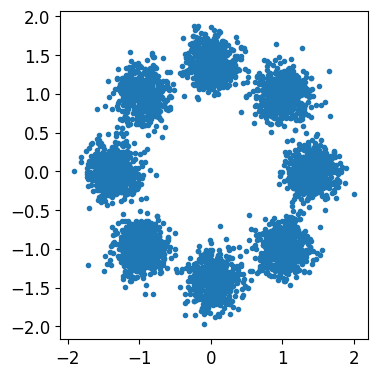

In [8]:
# plot data
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x[:, 0], x[:, 1], ".")
plt.tight_layout()
plt.show()

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(MLP, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        # layers.append(nn.ReLU(inplace=True))
        layers.append(nn.SiLU(inplace=True))

        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            # layers.append(nn.ReLU(inplace=True))
            layers.append(nn.SiLU(inplace=True))

        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [10]:
class CategoricalEncoder(nn.Module):
    """Output a categorical distribution"""
    def __init__(self, input_dim, output_dim, hidden_dims, tau=0.5):
        super().__init__()
        self.mlp = MLP(input_dim, output_dim, hidden_dims)
        self.tau = tau
    
    def forward(self, x):
        p = torch.softmax(self.mlp(x), dim=-1)
        z = F.gumbel_softmax(torch.log(p + 1e-6), tau=self.tau, hard=True)
        return z

class NormalEncoder(nn.Module):
    """Output mean and log std"""
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.mlp = MLP(input_dim, output_dim * 2, hidden_dims)
    
    def forward(self, x):
        return torch.chunk(self.mlp(x), 2, dim=-1)

class GMMEncoder(nn.Module):
    """Gaussian mixture posterior"""
    def __init__(self, input_dim, output_dim, tau=0.5, train_ls=False):
        super().__init__()
        self.tau = tau
        self.mu = nn.Parameter(torch.zeros(output_dim, input_dim))
        self.ls = nn.Parameter(torch.log(0.5 * torch.ones(output_dim, input_dim)), requires_grad=train_ls)
        # nn.init.xavier_normal_(self.mu)
        nn.init.normal_(self.mu, std=1.)

    def forward(self, x):
        logp = torch_dist.Normal(self.mu, self.ls.exp()).log_prob(x.unsqueeze(-2)).sum(-1)
        p = torch.softmax(logp, dim=-1)
        z = F.gumbel_softmax(torch.log(p + 1e-6), tau=self.tau, hard=True)
        return z
    
class Critic(nn.Module):
    """Compute critic features for inner product"""
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.mlp = MLP(input_dim, output_dim, hidden_dims)
    
    def forward(self, x):
        return self.mlp(x)

In [102]:
x_dim = x.shape[-1]
z_dim = 8

In [90]:
def train(encoder, critic_x, critic_z, baseline, step_function, loss_function):
    if critic_z is None:
        optimizer = torch.optim.Adam(
            list(encoder.parameters()) + list(critic_x.parameters()),
            lr=lr,
        )
    else:
        optimizer = torch.optim.Adam(
            list(encoder.parameters()) + list(critic_x.parameters()) + list(critic_z.parameters()),
            lr=lr,
        )

    history = []
    bar = tqdm(range(epochs))
    for e in bar:
        sample_idx = torch.randint(len(x), size=(batch_size,))
        x_batch = x[sample_idx]

        sample_idx_neg = torch.randint(len(x), size=(batch_size,))
        x_batch_neg = x[sample_idx_neg]
        out = step_function(encoder, critic_x, critic_z, baseline, x_batch, x_batch_neg)

        loss = loss_function(*out).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_description(f"e: {e}, loss: {loss:.2f}")
        history.append(loss.data.item())

    return history

In [11]:
def cross_entropy(p, q, eps=1e-6):
    logq = torch.log(q + eps)
    ce = -torch.sum(p * logq, dim=-1)
    return ce

def infonce_loss(h_x, h_z):
    e = torch.einsum("ih, jh -> ij", h_z, h_x)
    # e = F.cosine_similarity(h_z[:,None,:], h_x[None,:,:], dim=-1)
    p = torch.softmax(e, dim=-1)
    labels = torch.eye(len(h_x))
    loss = cross_entropy(labels, p)
    return loss

def print_grads(model):
    for n, p in model.named_parameters():
        if p is None:
            print(n, None)
        else:
            print(n, p.grad.data.norm())

### InfoNCE loss

In [38]:
def info_nce_step(encoder, critic_x, critic_z, baseline, x_batch, x_neg_batch):
    z_batch = encoder(x_batch)
    h_x = critic_x(x_batch)
    h_z = critic_z(z_batch) 
    return h_x, h_z

In [41]:
batch_size = 200
lr = 1e-4
epochs = 3000
h_dim = 100 # feature dimension used to compute inner product energy function
hidden_dims = [200, 200]

encoder = CategoricalEncoder(x_dim, z_dim, hidden_dims, tau=0.5)
critic_x = Critic(x_dim, h_dim, hidden_dims)
critic_z = Critic(z_dim, h_dim, hidden_dims)

history = train(encoder, critic_x, critic_z, None, info_nce_step, infonce_loss)

e: 2999, loss: 3.50: 100%|██████████| 3000/3000 [00:19<00:00, 152.99it/s]


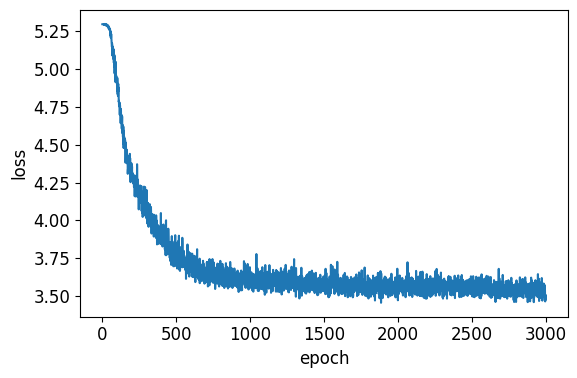

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.tight_layout()
plt.show()

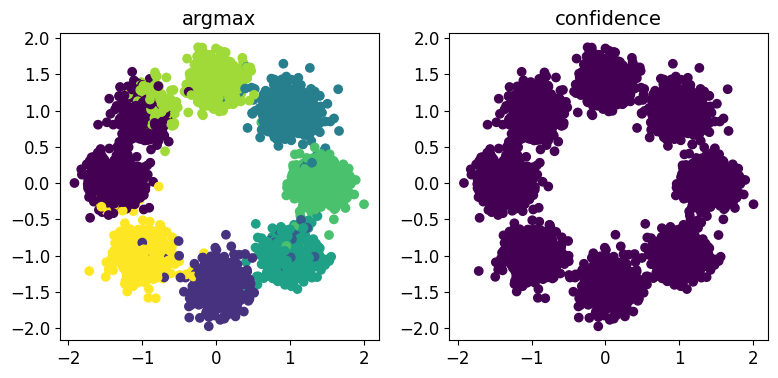

In [46]:
# visualize latent
with torch.no_grad():
    z_pred = encoder(x)
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x[:, 0], x[:, 1], c=z_pred.argmax(-1))
ax[1].scatter(x[:, 0], x[:, 1], c=z_pred.max(-1)[0])

ax[0].set_title("argmax")
ax[1].set_title("confidence")
plt.tight_layout()
plt.show()

In [95]:
def infonce_loss_joint(x, z, critic):
    z_ = z.unsqueeze(0).tile((x.shape[0], 1, 1))
    x_ = x.unsqueeze(1).tile((1, z.shape[0], 1))
    e = critic.forward(torch.cat([x_, z_], dim=-1)).squeeze(-1)
    p = torch.softmax(e, dim=-1)
    labels = torch.eye(len(z_))
    loss = cross_entropy(labels, p)
    return loss

def info_nce_step_joint(encoder, critic_x, critic_z, baseline, x_batch, x_neg_batch):
    z_batch = encoder(x_batch)
    return x_batch, z_batch, critic_x

In [98]:
# train categorical encoder joint critic
batch_size = 200
lr = 1e-3
epochs = 1000
hidden_dims = [200, 200]

encoder = CategoricalEncoder(x_dim, z_dim, hidden_dims, tau=0.1)
critic = Critic(x_dim + z_dim, 1, hidden_dims)
history = train(encoder, critic, None, None, info_nce_step_joint, infonce_loss_joint)

e: 999, loss: 3.99: 100%|██████████| 1000/1000 [01:19<00:00, 12.55it/s]


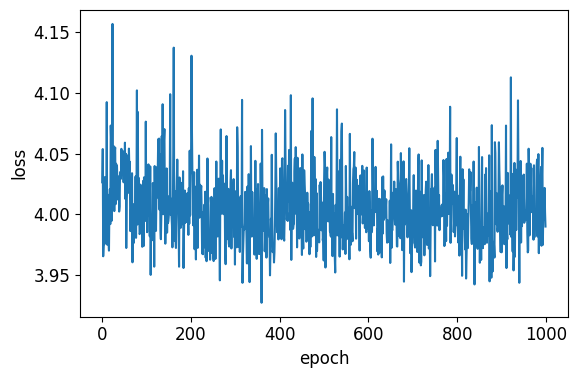

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.tight_layout()
plt.show()

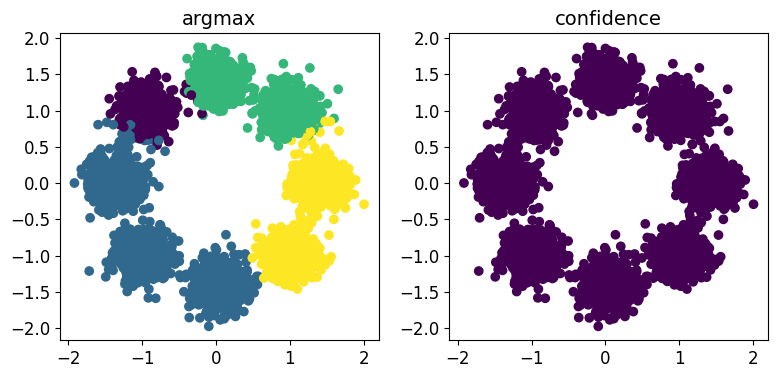

In [105]:
# visualize latent
with torch.no_grad():
    z_pred = encoder(x)
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x[:, 0], x[:, 1], c=z_pred.argmax(-1))
ax[1].scatter(x[:, 0], x[:, 1], c=z_pred.max(-1)[0])

ax[0].set_title("argmax")
ax[1].set_title("confidence")
plt.tight_layout()
plt.show()

In [ ]:
def info_nce_step(encoder, critic_x, critic_z, baseline, x_batch, x_neg_batch):
    z_batch = encoder(x_batch)
    h_x = critic_x(x_batch)
    h_z = critic_z(z_batch) 
    return h_x, h_z

In [108]:
# train gmm encode
batch_size = 100
encoder_lr = 1e-3
critic_lr = 1e-3
epochs = 1000

x_dim = x.shape[-1]
z_dim = 8
h_dim = 100 # feature dimension used to compute inner product energy function
hidden_dims = [200, 200]
encoder = GMMEncoder(x_dim, z_dim, tau=0.1, train_ls=True)
critic_x = Critic(x_dim, h_dim, hidden_dims)
critic_z = Critic(z_dim, h_dim, hidden_dims)

encoder_optimizer = torch.optim.Adam(
    encoder.parameters(),
    lr=encoder_lr,
)

critic_optimizer = torch.optim.Adam(
    list(critic_x.parameters()) + list(critic_z.parameters()),
    lr=critic_lr,
)

history = []
bar = tqdm(range(epochs))
for e in bar:
    sample_idx = torch.randint(len(x), size=(batch_size,))

    x_batch = x[sample_idx]
    z_batch = encoder(x_batch)
    h_x = critic_x(x_batch)
    h_z = critic_z(z_batch) 

    loss = infonce_loss(h_x, h_z).mean()
    
    encoder_optimizer.zero_grad()
    critic_optimizer.zero_grad()
    loss.backward()
    encoder_optimizer.step()
    critic_optimizer.step()

    bar.set_description(f"e: {e}, loss: {loss:.2f}")
    history.append(loss.data.item())

e: 999, loss: 3.04: 100%|██████████| 1000/1000 [00:04<00:00, 235.50it/s]


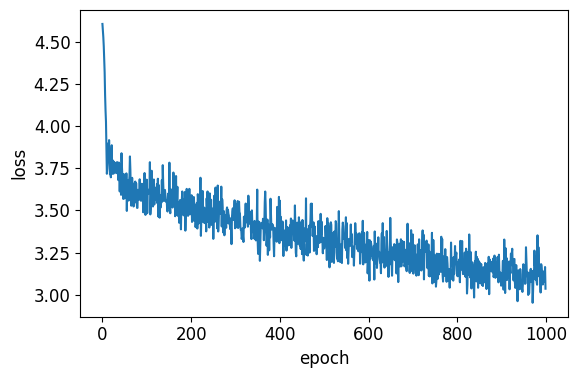

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.tight_layout()
plt.show()

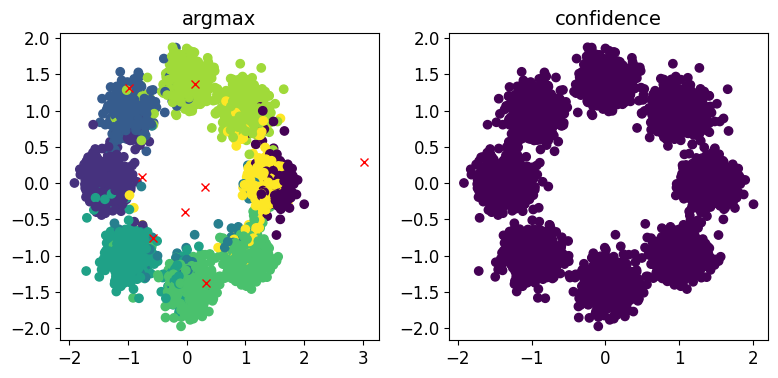

In [110]:
# visualize latent
with torch.no_grad():
    z_pred = encoder(x)
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x[:, 0], x[:, 1], c=z_pred.argmax(-1))
ax[1].scatter(x[:, 0], x[:, 1], c=z_pred.max(-1)[0])

ax[0].plot(encoder.mu.data[:, 0], encoder.mu.data[:, 1], "rx")

ax[0].set_title("argmax")
ax[1].set_title("confidence")
plt.tight_layout()
plt.show()

In [253]:
# train normal encoder
batch_size = 200
lr = 3e-5
epochs = 1000

x_dim = x.shape[-1]
z_dim = 1
h_dim = 256 # feature dimension used to compute inner product energy function
hidden_dims = [200, 200, 200]
encoder = NormalEncoder(x_dim, z_dim, hidden_dims)
critic_x = Critic(x_dim, h_dim, hidden_dims)
critic_z = Critic(z_dim, h_dim, hidden_dims)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(critic_x.parameters()) + list(critic_z.parameters()),
    lr=lr,
)

history = []
bar = tqdm(range(epochs))
for e in bar:
    sample_idx = torch.randint(len(x), size=(batch_size,))

    x_batch = x[sample_idx]
    z_mu, z_ls = encoder(x_batch)
    z_batch = torch_dist.Normal(z_mu, z_ls.exp()).rsample()    
    h_x = critic_x(x_batch)
    h_z = critic_z(z_batch)

    loss = infonce_loss(h_x, h_z).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    bar.set_description(f"e: {e}, loss: {loss:.2f}")
    history.append(loss.data.item())

e: 999, loss: 1.93: 100%|██████████| 1000/1000 [00:09<00:00, 106.95it/s]


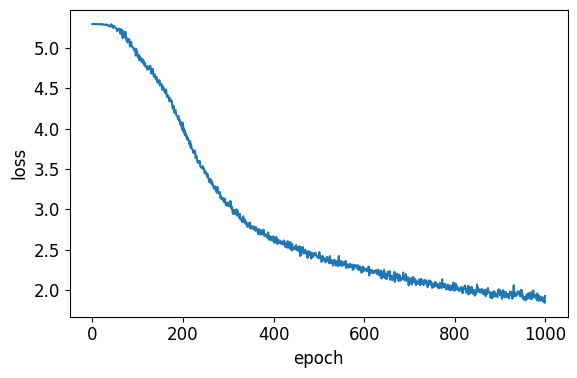

In [254]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.tight_layout()
plt.show()

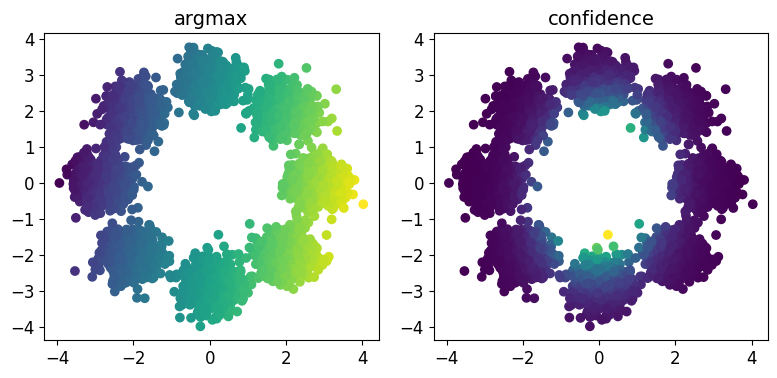

In [255]:
# visualize latent
with torch.no_grad():
    z_pred_mu, z_pred_ls = encoder(x)
    z_pred_std = z_pred_ls.exp()
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x[:, 0], x[:, 1], c=z_pred_mu)
ax[1].scatter(x[:, 0], x[:, 1], c=z_pred_std)

ax[0].set_title("argmax")
ax[1].set_title("confidence")
plt.tight_layout()
plt.show()

### TUBA loss

In [47]:
def tuba_loss(h_x_pos, h_x_neg, h_z, b_z):
    e_pos = torch.sum(h_x_pos * h_z, dim=-1, keepdim=True)
    e_neg = torch.sum(h_x_neg * h_z, dim=-1, keepdim=True)
    loss = e_pos - torch.exp(e_neg - b_z) - b_z + 1
    return -loss

def tuba_step(encoder, critic_x, critic_z, baseline, x_batch, x_batch_neg):
    z_batch = encoder(x_batch)
    h_x_pos = critic_x(x_batch)
    h_x_neg = critic_x(x_batch_neg)
    h_z = critic_z(z_batch)
    b_z = baseline(z_batch)

    return h_x_pos, h_x_neg, h_z, b_z

In [51]:
batch_size = 200
lr = 1e-4
epochs = 1000
hidden_dims = [500, 500]

encoder = CategoricalEncoder(x_dim, z_dim, hidden_dims)
critic_x = Critic(x_dim, h_dim, hidden_dims)
critic_z = Critic(z_dim, h_dim, hidden_dims)
baseline = Critic(z_dim, 1, hidden_dims)

history = train(encoder, critic_x, critic_z, baseline, tuba_step, tuba_loss)

e: 999, loss: -1.43: 100%|██████████| 1000/1000 [00:16<00:00, 59.76it/s]


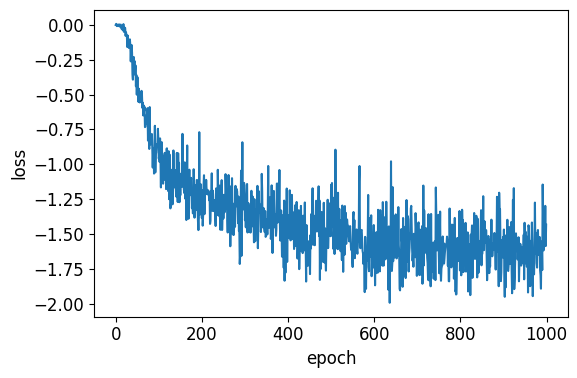

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.tight_layout()
plt.show()

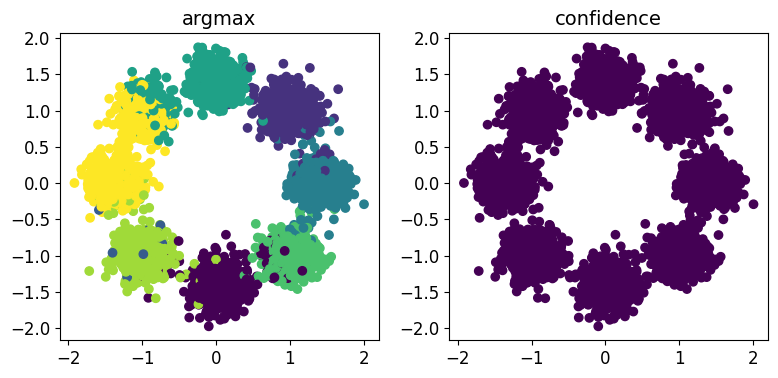

In [53]:
# visualize latent
with torch.no_grad():
    z_pred = encoder(x)
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x[:, 0], x[:, 1], c=z_pred.argmax(-1))
ax[1].scatter(x[:, 0], x[:, 1], c=z_pred.max(-1)[0])

ax[0].set_title("argmax")
ax[1].set_title("confidence")
plt.tight_layout()
plt.show()

# NWJ

In [56]:
def nwj_loss(h_x_pos, h_x_neg, h_z, const_e):
    e_pos = torch.sum(h_x_pos * h_z, dim=-1, keepdim=True)
    e_neg = torch.sum(h_x_neg * h_z, dim=-1, keepdim=True)
    loss = e_pos - (1 / const_e) * torch.exp(e_neg)
    return -loss

def nwj_step(encoder, critic_x, critic_z, const_e, x_batch, x_batch_neg):
    z_batch = encoder(x_batch)
    h_x_pos = critic_x(x_batch)
    h_x_neg = critic_x(x_batch_neg)
    h_z = critic_z(z_batch)
    return h_x_pos, h_x_neg, h_z, const_e

In [64]:
batch_size = 200
lr = 1e-4
epochs = 1000
hidden_dims = [500, 500]

encoder = CategoricalEncoder(x_dim, z_dim, hidden_dims)
critic_x = Critic(x_dim, h_dim, hidden_dims)
critic_z = Critic(z_dim, h_dim, hidden_dims)
baseline = 1.

history = train(encoder, critic_x, critic_z, baseline, nwj_step, nwj_loss)

e: 999, loss: -0.54: 100%|██████████| 1000/1000 [00:14<00:00, 68.11it/s]


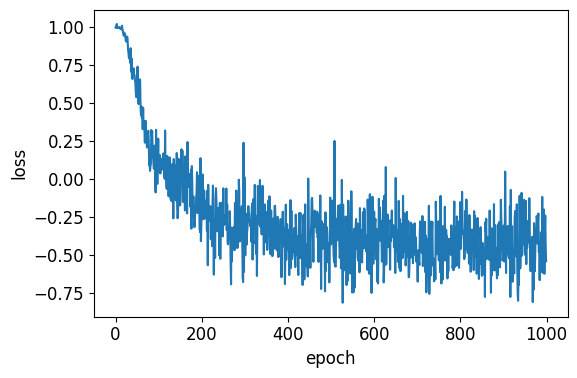

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.tight_layout()
plt.show()

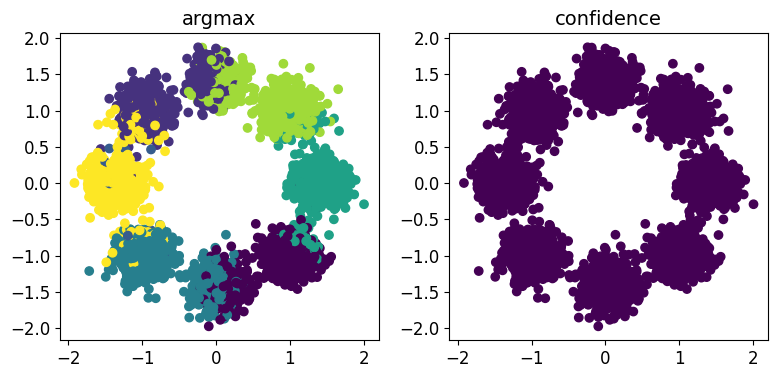

In [66]:
# visualize latent
with torch.no_grad():
    z_pred = encoder(x)
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x[:, 0], x[:, 1], c=z_pred.argmax(-1))
ax[1].scatter(x[:, 0], x[:, 1], c=z_pred.max(-1)[0])

ax[0].set_title("argmax")
ax[1].set_title("confidence")
plt.tight_layout()
plt.show()

# Jensen-Shannon

In [111]:
def js_loss(h_x_pos, h_x_neg, h_z):
    v_pos = F.softplus(torch.sum(h_x_pos * h_z, dim=-1, keepdim=True))
    v_neg = F.softplus(torch.sum(h_x_neg * h_z, dim=-1, keepdim=True))
    loss = 1 + v_pos - torch.exp(v_neg)
    return -loss

def js_step(encoder, critic_x, critic_z, baseline, x_batch, x_batch_neg):
    z_batch = encoder(x_batch)
    h_x_pos = critic_x(x_batch)
    h_x_neg = critic_x(x_batch_neg)
    h_z = critic_z(z_batch)
    return h_x_pos, h_x_neg, h_z

In [121]:
batch_size = 1024
lr = 1e-4
epochs = 5000
h_dim = 512 # feature dimension used to compute inner product energy function
hidden_dims = [32]

encoder = CategoricalEncoder(x_dim, z_dim, hidden_dims)
critic_x = Critic(x_dim, h_dim, hidden_dims)
critic_z = Critic(z_dim, h_dim, hidden_dims)
baseline = None

history = train(encoder, critic_x, critic_z, baseline, js_step, js_loss)

e: 4999, loss: -0.68: 100%|██████████| 5000/5000 [00:49<00:00, 101.29it/s]


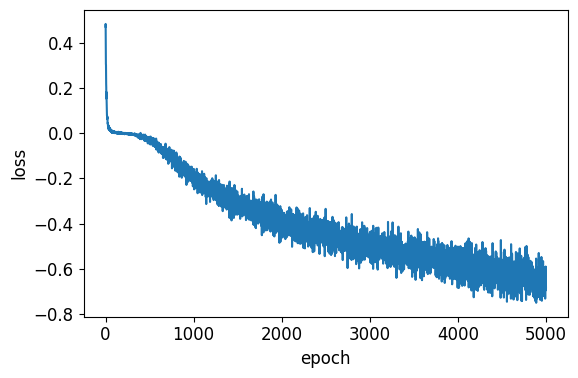

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.tight_layout()
plt.show()

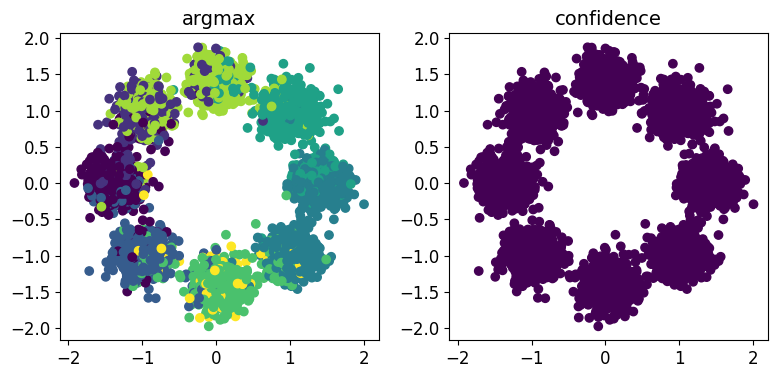

In [124]:
# visualize latent
with torch.no_grad():
    z_pred = encoder(x)
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x[:, 0], x[:, 1], c=z_pred.argmax(-1))
ax[1].scatter(x[:, 0], x[:, 1], c=z_pred.max(-1)[0])

ax[0].set_title("argmax")
ax[1].set_title("confidence")
plt.tight_layout()
plt.show()